In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENAI_API_KEY=your_openai_api_key_here
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: OPENAI_API_KEY=your_openai_api_key_here
env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [9]:
import langgraph


In [13]:
# Import required libraries
import os
import json
import sqlite3
from typing import List, Dict, Any, Optional
import chromadb
from chromadb.config import Settings

# LangChain and LangGraph imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Local imports
from utils import describe_database


## Setup Vector Database and Load SQL Examples


In [3]:
# Initialize embeddings and ChromaDB
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialize ChromaDB (clean slate)
chroma_client = chromadb.PersistentClient(
    path="./chromadb_react_agent",
    settings=Settings(anonymized_telemetry=False)
)

# Clean up existing collection if it exists
try:
    chroma_client.delete_collection("sql_examples")
except Exception:
    pass  # Ignore if collection doesn't exist

# Initialize vector store
vector_store = Chroma(
    client=chroma_client,
    collection_name="sql_examples",
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)

print("✅ Vector database initialized")


✅ Vector database initialized


In [4]:
# Load and prepare SQL examples from dev.json
with open('../dev.json', 'r') as f:
    dev_data = json.load(f)

print(f"📚 Loaded {len(dev_data)} SQL examples")
print(f"Example: {dev_data[0]['question'][:100]}...")


📚 Loaded 1534 SQL examples
Example: What is the highest eligible free rate for K-12 students in the schools in Alameda County?...


In [5]:
db_names = set([d['db_id'] for d in dev_data])

db_names

{'california_schools',
 'card_games',
 'codebase_community',
 'debit_card_specializing',
 'european_football_2',
 'financial',
 'formula_1',
 'student_club',
 'superhero',
 'thrombosis_prediction',
 'toxicology'}

In [6]:
# Create documents from SQL examples
from langchain_core.documents import Document

documents = []
for item in dev_data:
    # Create comprehensive document with all relevant information
    evidences = [e.strip() for e in item['evidence'].split(';') if e.strip()]
    
    for evidence in evidences:
        doc = Document(
            page_content=evidence,
            metadata={
                "db_id": item["db_id"],
                "question": item["question"],
                "sql": item["SQL"]
            }
        )
        documents.append(doc)

# Add documents to vector store
print(f"📤 Adding {len(documents)} documents to vector store...")
# vector_store.add_documents(documents)
print(f"✅ Added {len(documents)} SQL evidence examples to the vector store")

# Show database distribution
db_counts = {}
for item in dev_data:
    db_id = item['db_id']
    db_counts[db_id] = db_counts.get(db_id, 0) + 1

print(f"\n📊 Available databases:")
for db_id, count in sorted(db_counts.items()):
    print(f"  - {db_id}: {count} examples")


📤 Adding 2680 documents to vector store...
✅ Added 2680 SQL evidence examples to the vector store

📊 Available databases:
  - california_schools: 89 examples
  - card_games: 191 examples
  - codebase_community: 186 examples
  - debit_card_specializing: 64 examples
  - european_football_2: 129 examples
  - financial: 106 examples
  - formula_1: 174 examples
  - student_club: 158 examples
  - superhero: 129 examples
  - thrombosis_prediction: 163 examples
  - toxicology: 145 examples


## Define ReAct Agent Tools


In [7]:
@tool
def look_up_evidence(query: str, database_id: str = "", k: int = 5) -> str:
    """
    Look up relevant SQL evidence/examples from the vector database.
    
    Args:
        query: The question or query to find relevant SQL examples for
        database_id: Optional database ID to filter results (e.g., 'formula_1', 'california_schools')
        k: Number of examples to retrieve (default: 5)
    
    Returns:
        String containing relevant SQL evidence and examples
    """
    
    try:
        # Perform similarity search with optional filtering
        search_kwargs = {"k": k}
        if database_id:
            search_kwargs["filter"] = {"db_id": database_id}
        
        results = vector_store.similarity_search_with_score(query, **search_kwargs)
        
        if not results:
            return f"No relevant evidence found for query: '{query}'"
        
        # Format results
        evidence_text = f"Found {len(results)} relevant examples:\n\n"
        
        for i, (doc, score) in enumerate(results, 1):
            similarity = 1 - score  # Convert distance to similarity
            evidence_text += f"Example {i} (similarity: {similarity:.3f}):\n"
            evidence_text += f"Database: {doc.metadata['db_id']}\n"
            evidence_text += f"Evidence: {doc.page_content}\n"
            if 'question' in doc.metadata:
                evidence_text += f"Related Question: {doc.metadata['question']}\n"
            if 'sql' in doc.metadata:
                evidence_text += f"SQL Example: {doc.metadata['sql']}\n"
            evidence_text += "-" * 50 + "\n"
        
        return evidence_text
        
    except Exception as e:
        error_msg = f"Error looking up evidence: {str(e)}"
        return error_msg


In [8]:
@tool
def run_sql_against_database(sql_query: str, database_id: str) -> str:
    """
    Execute a SQL query against the specified database.
    
    Args:
        sql_query: The SQL query to execute
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the query results or error message
    """
    
    try:
        # Construct database path
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        # Connect and execute query
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        cursor.execute(sql_query)
        
        # Get results
        columns = [description[0] for description in cursor.description] if cursor.description else []
        results = cursor.fetchall()
        
        conn.close()
        
        # Format results
        if not results:
            result_text = "Query executed successfully but returned no results."
        else:
            result_text = f"Query executed successfully! Found {len(results)} row(s):\n\n"
            
            # Add column headers
            if columns:
                result_text += " | ".join(columns) + "\n"
                result_text += "-" * (len(" | ".join(columns))) + "\n"
            
            # Add data rows (limit to first 10 for readability)
            for row in results[:10]:
                result_text += " | ".join(str(cell) if cell is not None else "NULL" for cell in row) + "\n"
            
            if len(results) > 10:
                result_text += f"\n... and {len(results) - 10} more row(s)"
        
        return result_text
        
    except Exception as e:
        error_msg = f"Error executing SQL query: {str(e)}"
        return error_msg


@tool
def get_database_schema(database_id: str) -> str:
    """
    Get the schema description for a specific database.
    
    Args:
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the database schema information including tables, columns, and relationships
    """
    
    try:
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        schema = describe_database(db_path)
        return f"Database Schema for '{database_id}':\n\n{schema}"
        
    except Exception as e:
        error_msg = f"Error getting database schema: {str(e)}"
        return error_msg


@tool
def log_evidence(text: str, database_id: str) -> str:
    """
    Write evidence text to a scratchpad to look up later for another SQL query.
    Rejects the request if the database_id is not a known database.

    E.g. "Note to self: The table for countries is called "Country" and not aNation" like I previously thought"

    Args:
        text: The evidence text to store (e.g. "The foreign key in the 'sales' table to the customer is called 'buyer_uuid'")
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')

    Returns:
        Acknowledgement message.
    """
    # List of known/allowed database IDs
    known_databases = db_names

    if database_id not in known_databases:
        return f"Error: '{database_id}' is not a known database. Allowed databases: {', '.join(known_databases)}"

    try:
        # Create a Document object with the evidence text
        doc = Document(
            page_content=text,
            metadata={
                "db_id": database_id,
                "source": "agent_learned_evidence"  # Tag to identify agent-learned evidence
            }
        )
        
        # Add the document to the vector store
        vector_store.add_documents([doc])
        
        return f"Evidence successfully added to database '{database_id}'. Document added with content: '{text[:100]}{'...' if len(text) > 100 else ''}'"
        
    except Exception as e:
        return f"Error adding evidence to vector store: {str(e)}"


## Create the ReAct Agent


In [9]:
from os import getenv

# Initialize the language model
llm = ChatOpenAI(
  model="openai/gpt-4.1-mini", 
  temperature=0,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
  extra_body={
      "usage": {"include": True}
  })

def create_agent_with_or_without_memory(memory: bool = True):
  tools = [look_up_evidence, run_sql_against_database, get_database_schema]
  if memory:
    print("Adding log_evidence tool to our agent")
    tools.append(log_evidence)

  # Create the ReAct agent using LangGraph's create_react_agent
  checkpointer = MemorySaver()  # For conversation memory

  react_agent = create_react_agent(
      model=llm,
      tools=tools,
      checkpointer=checkpointer,
      prompt=f"""You are a helpful SQL assistant. You can:
  1. Look up relevant SQL evidence/examples from a vector database using the `look_up_evidence` tool
  2. Execute SQL queries against databases using the `run_sql_against_database` tool
  3. Describe the database using the `get_database_schema` tool
  {'4. If you couldn\'t find any good evidence from `look_up_evidence` tool, log your own to retrieve later for future efficient queries using the `log_evidence` tool. Use it as a memory store for yourself.' if memory is True else ''}

  {'If you are going to use the `log_evidence` tool, it should be the last tool you call right before giving an answer to the user' if memory is True else ''}

  When a user asks a question that could be answered with SQL:
  1. First, describe the database using the `get_database_schema` tool if you haven't already
  2. Then, look up evidence for similar SQL examples that might help using the `look_up_evidence` tool
  3. Generate and execute the appropriate SQL query using the database_id from the evidence using the `run_sql_against_database` tool
  {'4. Store information that helped you generate a SQL query as a memory to the database using the `log_evidence` tool' if memory is True else ''}
  
  When you're done, provide a clear answer to the user. Be thorough in your reasoning and explain your approach.

  Available databases:
    - california_schools
    - card_games
    - codebase_community
    - debit_card_specializing
    - european_football_2
    - financial
    - formula_1
    - student_club
    - superhero
    - thrombosis_prediction
    - toxicology"""
  )

  print("✅ ReAct agent created successfully!")
  return react_agent


## Test the ReAct Agent


In [10]:
import json

# Stream events with a sample query
def stream_agent_events(react_agent, question: str, thread_id: str = "stream_test"):
    """Stream events from the ReAct agent for a given question"""
    print(f"\n{'='*60}")
    print(f"🔄🟢 Streaming ReAct Agent Events")
    print(f'🧑 User said: {question}')
    print(f"{'='*60}\n")
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # The agent must support streaming; assume .stream() yields events
    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    print(f'🤖 Agent said: {message.content}')
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        if 'function' in tool_call:
                            print(f'🛠️ Tool called: {tool_call["function"]["name"]}')
                            if 'arguments' in tool_call["function"]:
                                for tool_arg_key, tool_arg_value in json.loads(tool_call["function"]["arguments"]).items():
                                    print(f'   🔑 {tool_arg_key}: {tool_arg_value}')
        elif 'tools' in event:
            for message in event['tools']['messages']:
                print(f'📦 Tool response: {message.content[:100]}...')
        else:
            print(f'⚡ Event: {event}')
    
    print(f"\n{'='*60}")

In [11]:
long_term_memory_react_agent = create_agent_with_or_without_memory(memory=True)

Adding log_evidence tool to our agent
✅ ReAct agent created successfully!


In [12]:
# Sample query
stream_agent_events(
    long_term_memory_react_agent,
    "What tools do you have access to?",
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: What tools do you have access to?

🤖 Agent said: I have access to the following tools:

1. look_up_evidence: To look up relevant SQL evidence/examples from a vector database.
2. run_sql_against_database: To execute SQL queries against specified databases.
3. get_database_schema: To describe the schema of a specific database.
4. log_evidence: To write evidence text to a scratchpad for future reference.

I can use these tools to help answer your SQL-related questions or queries about specific databases. If you have a question or task, please let me know!



In [13]:
# Sample query
stream_agent_events(
    long_term_memory_react_agent,
    "List the top 3 teams with the most wins in F1 in 1972",
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: List the top 3 teams with the most wins in F1 in 1972

🛠️ Tool called: get_database_schema
   🔑 database_id: formula_1
📦 Tool response: Database Schema for 'formula_1':


🧱 Table: circuits
   🔸 circuitId (INTEGER)
   🔸 circuitRef (TEXT)...
🛠️ Tool called: run_sql_against_database
   🔑 sql_query: SELECT c.name AS team_name, COUNT(*) AS wins
FROM results r
JOIN races ra ON r.raceId = ra.raceId
JOIN constructors c ON r.constructorId = c.constructorId
WHERE ra.year = 1972 AND r.position = 1
GROUP BY c.name
ORDER BY wins DESC
LIMIT 3;
   🔑 database_id: formula_1
📦 Tool response: Query executed successfully! Found 3 row(s):

team_name | wins
----------------
Team Lotus | 5
Tyrre...
🤖 Agent said: The top 3 teams with the most wins in Formula 1 in 1972 are:

1. Team Lotus with 5 wins
2. Tyrrell with 4 wins
3. McLaren with 1 win

If you need more details or further analysis, feel free to ask!



# Evaluating our Agent with a prompt

In [14]:
print(len(vector_store.get()['documents']))

0


In [15]:
import time
import json

RECURSION_LIMIT = 20

def get_agent_final_response(react_agent, question: str, thread_id: str = "single_query"):
    """
    Takes in a query and returns the AI's final response from the ReAct agent.
    Also returns metadata including tool call count, tool latencies, message latencies, overall latency, and total cost.
    Prints out each agent message as it is received.
    """
    config = {"configurable": {"thread_id": thread_id}, "recursion_limit": RECURSION_LIMIT}
    final_response = None

    tool_calls = 0
    tool_latencies = []
    tool_messages = []
    message_latencies = []
    ai_messages = []
    total_cost = 0.0
    all_costs = []
    overall_start = time.time()
    last_message_time = overall_start

    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        now = time.time()
        # Track message latency
        if 'agent' in event:
            message_latency = now - last_message_time
            message_latencies.append(message_latency)
            last_message_time = now
            ai_messages.append(event['agent']['messages'][0].content)

            # Extract cost from response_metadata if present
            for message in event['agent']['messages']:
                # Add up cost if available in response_metadata
                response_metadata = {}
                # Try both .additional_kwargs and direct attribute for response_metadata
                if hasattr(message, "response_metadata") and message.response_metadata:
                    response_metadata = message.response_metadata
                elif message.additional_kwargs and "response_metadata" in message.additional_kwargs:
                    response_metadata = message.additional_kwargs["response_metadata"]
                # Try to extract cost from token_usage
                if "token_usage" in response_metadata and "cost" in response_metadata["token_usage"]:
                    try:
                        cost_val = float(response_metadata["token_usage"]["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass
                # Sometimes cost may be at the top level
                elif "cost" in response_metadata:
                    try:
                        cost_val = float(response_metadata["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass

        # Parse tool calls from agent messages (matching stream_agent_events logic)
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    final_response = message.content  # Overwrite, so last is final
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        tool_calls += 1
                        # Optionally, extract tool name and arguments for tool_messages
                        if 'function' in tool_call:
                            tool_name = tool_call["function"].get("name", None)
                            tool_args = None
                            if "arguments" in tool_call["function"]:
                                try:
                                    tool_args = json.loads(tool_call["function"]["arguments"])
                                except Exception:
                                    tool_args = tool_call["function"]["arguments"]
                            tool_messages.append({"name": tool_name, "arguments": tool_args})
                        # Estimate tool latency as time since last message
                        tool_latencies.append(message_latency)

        # Also handle 'tools' event type for tool responses (optional, for completeness)
        elif 'tools' in event:
            for message in event['tools']['messages']:
                # You may want to log or store tool responses here if needed
                pass

    overall_latency = time.time() - overall_start

    metadata = {
        "tool_calls": tool_calls,
        "tool_latencies": tool_latencies,
        "tool_messages": tool_messages,
        "message_latencies": message_latencies,
        "overall_latency": overall_latency,
        "ai_messages": ai_messages,
        "cost": total_cost,
        "all_costs": all_costs
    }

    return final_response, metadata


In [16]:
get_agent_final_response(
    long_term_memory_react_agent,
    "List the top 3 teams with the most wins in F1 in 1972",
    "formula1_stream_new"
)

('The top 3 teams with the most wins in F1 in 1972 are:\n\n1. Team Lotus with 5 wins\n2. Tyrrell with 4 wins\n3. McLaren with 1 win\n\nThis was determined by counting the number of race wins (position = 1) for each team in the 1972 season.',
 {'tool_calls': 3,
  'tool_latencies': [0.8025622367858887,
   5.346657037734985,
   2.6775689125061035],
  'tool_messages': [{'name': 'get_database_schema',
    'arguments': {'database_id': 'formula_1'}},
   {'name': 'run_sql_against_database',
    'arguments': {'sql_query': 'SELECT c.name AS team_name, COUNT(*) AS wins\nFROM results r\nJOIN races ra ON r.raceId = ra.raceId\nJOIN constructors c ON r.constructorId = c.constructorId\nWHERE ra.year = 1972 AND r.position = 1\nGROUP BY c.name\nORDER BY wins DESC\nLIMIT 3;',
     'database_id': 'formula_1'}},
   {'name': 'log_evidence',
    'arguments': {'text': 'To find the top 3 teams with the most wins in F1 in 1972, we join the results, races, and constructors tables. We filter by year 1972 and posi

In [17]:
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Define the Pydantic model for structured output
class ScoreResponse(BaseModel):
    reasoning: str = Field(description="The reasoning process of what score you should pick")
    score: int = Field(description="An integer between 0 and 3 representing the correctness of the AI response compared to the ground truth")

# Create a prompt template for scoring AI responses against ground truth
score_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert evaluator. "
            "Given an AI's response to a question and the ground truth answer, "
            "score the AI's response on a scale from 0 to 3 based on correctness:\n"
            "0 = Completely incorrect or irrelevant\n"
            "1 = Partially correct, but with major errors or omissions\n"
            "2 = Mostly correct, but with minor errors or missing details\n"
            "3 = Completely correct and matches the ground truth"
        )
    ),
    (
        "human",
        (
            "Question: {question}\n"
            "AI Response: {ai_response}\n"
            "Ground Truth: {ground_truth}\n\n"
            "Score the AI response from 0 to 3."
        )
    )
])

# using a small model because I think this task is "easy"
# TODO Sinan note, positional bias might be a factor here it's technically mult choice with 4 options
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Create the structured LLM using with_structured_output
structured_llm = llm.with_structured_output(ScoreResponse)


In [18]:
eval_results = []

In [ ]:
from tqdm import tqdm
import time
# shuffle dev_data (which is a list)
from random import shuffle

shuffle(dev_data)

In [37]:


only_do = None
last_db_size = len(vector_store.get()['documents'])
for idx, example in tqdm(enumerate(dev_data), total=len(dev_data)):
    if idx < len(eval_results):
        continue
    if only_do and idx >= only_do:
        break
    db_path = f"../dbs/dev_databases/{example['db_id']}/{example['db_id']}.sqlite"
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    
    try:
        try:
            cur.execute(example['SQL'])
            ground_truth_answer = cur.fetchall()
            final_response, metadata = get_agent_final_response(
                long_term_memory_react_agent,
                example['question'], f'{example["db_id"]}_eval_{idx}_{time.time()}'
                )
            
            # run the rubric
            rubric_response = structured_llm.invoke(
                score_prompt.format(
                    question=example['question'],
                    ai_response=final_response,
                    ground_truth=ground_truth_answer
                )
            )
            if len(vector_store.get()['documents']) != last_db_size:
                print(f"Vector store size changed from {last_db_size} to {len(vector_store.get()['documents'])}")
                last_db_size = len(vector_store.get()['documents'])
            metadata.update({'vector_store_size': len(vector_store.get()['documents'])})
            metadata.update(rubric_response)
            metadata.update({'final_response': final_response, 'question': example['question'], 'ground_truth_answer': ground_truth_answer, 'difficulty': example['difficulty']})
            eval_results.append(metadata)
        except Exception as e:
            # Optionally, you can log the error here if desired
            print(str(e))
            if 'recursion limit' in str(e).lower():
                metadata.update({'tool_calls': RECURSION_LIMIT, 'score': 0})
                eval_results.append(metadata)
            continue
    finally:
        cur.close()
        conn.close()

 25%|██▌       | 387/1534 [00:21<01:21, 14.06it/s]

Vector store size changed from 135 to 136


 25%|██▌       | 388/1534 [00:30<02:15,  8.48it/s]

Vector store size changed from 136 to 137


 26%|██▌       | 393/1534 [01:17<11:28,  1.66it/s]

Vector store size changed from 137 to 138


 26%|██▌       | 400/1534 [02:02<50:46,  2.69s/it]

Vector store size changed from 138 to 139


 26%|██▋       | 406/1534 [02:49<2:12:37,  7.05s/it]

Vector store size changed from 139 to 140


 27%|██▋       | 409/1534 [03:19<2:48:17,  8.98s/it]

Vector store size changed from 140 to 141


 27%|██▋       | 415/1534 [03:56<2:06:34,  6.79s/it]

Vector store size changed from 141 to 142


 27%|██▋       | 418/1534 [04:18<2:21:56,  7.63s/it]

Vector store size changed from 142 to 143


 27%|██▋       | 419/1534 [04:28<2:35:47,  8.38s/it]

Vector store size changed from 143 to 144


 27%|██▋       | 421/1534 [04:40<2:10:27,  7.03s/it]

Vector store size changed from 144 to 145


 28%|██▊       | 433/1534 [06:14<2:30:05,  8.18s/it]

Vector store size changed from 145 to 146


 28%|██▊       | 434/1534 [06:23<2:31:40,  8.27s/it]

Vector store size changed from 146 to 147


 29%|██▊       | 438/1534 [07:01<2:43:17,  8.94s/it]

Vector store size changed from 147 to 148


 29%|██▉       | 442/1534 [07:41<3:01:01,  9.95s/it]

Vector store size changed from 148 to 149


 29%|██▉       | 443/1534 [07:50<2:57:30,  9.76s/it]

Vector store size changed from 149 to 150


 29%|██▉       | 444/1534 [07:59<2:51:11,  9.42s/it]

Vector store size changed from 150 to 151


 29%|██▉       | 446/1534 [08:10<2:18:37,  7.64s/it]

Vector store size changed from 151 to 152


 29%|██▉       | 448/1534 [08:24<2:12:51,  7.34s/it]

Vector store size changed from 152 to 153


 29%|██▉       | 450/1534 [08:36<2:00:20,  6.66s/it]

Vector store size changed from 153 to 154


 29%|██▉       | 451/1534 [08:43<2:02:22,  6.78s/it]

Vector store size changed from 154 to 155


 29%|██▉       | 452/1534 [08:51<2:08:11,  7.11s/it]

Vector store size changed from 155 to 156


 30%|██▉       | 454/1534 [09:07<2:23:00,  7.94s/it]

Vector store size changed from 156 to 157


 30%|██▉       | 458/1534 [09:38<2:37:17,  8.77s/it]

Vector store size changed from 157 to 158


 30%|██▉       | 459/1534 [09:49<2:48:40,  9.41s/it]

Vector store size changed from 158 to 159


 30%|███       | 462/1534 [10:12<2:33:03,  8.57s/it]

Vector store size changed from 159 to 160


 30%|███       | 465/1534 [10:29<2:00:50,  6.78s/it]

Vector store size changed from 160 to 161


 30%|███       | 467/1534 [10:51<2:31:55,  8.54s/it]

Vector store size changed from 161 to 162


 31%|███       | 468/1534 [11:03<2:53:13,  9.75s/it]

Vector store size changed from 162 to 163


 31%|███       | 470/1534 [11:17<2:27:34,  8.32s/it]

Vector store size changed from 163 to 164


 31%|███       | 471/1534 [11:29<2:50:00,  9.60s/it]

Vector store size changed from 164 to 165


 31%|███       | 473/1534 [11:54<3:19:54, 11.30s/it]

Vector store size changed from 165 to 166


 31%|███       | 476/1534 [12:22<2:58:10, 10.10s/it]

Vector store size changed from 166 to 167


 31%|███       | 477/1534 [12:32<2:53:36,  9.85s/it]

Vector store size changed from 167 to 168


 31%|███       | 478/1534 [12:40<2:44:50,  9.37s/it]

Vector store size changed from 168 to 169


 31%|███       | 479/1534 [12:47<2:31:45,  8.63s/it]

Vector store size changed from 169 to 170


 31%|███▏      | 482/1534 [13:18<3:05:46, 10.60s/it]

Vector store size changed from 170 to 171


 32%|███▏      | 485/1534 [13:48<3:07:06, 10.70s/it]

Vector store size changed from 171 to 172


 32%|███▏      | 486/1534 [13:54<2:42:28,  9.30s/it]

Vector store size changed from 172 to 173


 32%|███▏      | 491/1534 [14:33<2:25:50,  8.39s/it]

Vector store size changed from 173 to 174


 32%|███▏      | 494/1534 [14:57<2:23:06,  8.26s/it]

Vector store size changed from 174 to 175


 32%|███▏      | 495/1534 [15:04<2:18:30,  8.00s/it]

Vector store size changed from 175 to 176


 32%|███▏      | 497/1534 [15:24<2:40:05,  9.26s/it]

Vector store size changed from 176 to 177


 32%|███▏      | 498/1534 [15:34<2:43:22,  9.46s/it]

Vector store size changed from 177 to 178


 33%|███▎      | 500/1534 [15:54<2:41:07,  9.35s/it]

Vector store size changed from 178 to 179


 33%|███▎      | 504/1534 [16:28<2:35:39,  9.07s/it]

Vector store size changed from 179 to 180


 33%|███▎      | 507/1534 [16:52<2:25:51,  8.52s/it]

Vector store size changed from 180 to 181


 33%|███▎      | 509/1534 [17:09<2:28:29,  8.69s/it]

Vector store size changed from 181 to 182


 33%|███▎      | 512/1534 [17:33<2:24:24,  8.48s/it]

Vector store size changed from 182 to 183


 33%|███▎      | 513/1534 [17:46<2:47:32,  9.85s/it]

Vector store size changed from 183 to 184


 34%|███▎      | 514/1534 [17:55<2:43:34,  9.62s/it]

Error code: 400 - {'error': {'message': "This model's maximum context length is 1047576 tokens. However, your messages resulted in 1110604 tokens (including 83 in the response_format schemas.). Please reduce the length of the messages or schemas.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


 34%|███▎      | 515/1534 [18:05<2:44:11,  9.67s/it]

Vector store size changed from 184 to 185


 34%|███▍      | 522/1534 [18:58<2:18:47,  8.23s/it]

Vector store size changed from 185 to 186


 34%|███▍      | 524/1534 [19:13<2:16:23,  8.10s/it]

Vector store size changed from 186 to 187


 34%|███▍      | 526/1534 [19:28<2:11:11,  7.81s/it]

Vector store size changed from 187 to 188


 34%|███▍      | 527/1534 [19:37<2:15:50,  8.09s/it]

Vector store size changed from 188 to 189


 35%|███▍      | 533/1534 [20:36<2:38:32,  9.50s/it]

Vector store size changed from 189 to 190


 35%|███▍      | 535/1534 [20:51<2:24:11,  8.66s/it]

Vector store size changed from 190 to 191


 35%|███▌      | 537/1534 [21:05<2:11:12,  7.90s/it]

Vector store size changed from 191 to 192


 35%|███▌      | 539/1534 [21:29<2:52:52, 10.42s/it]

Vector store size changed from 192 to 193


 35%|███▌      | 540/1534 [21:40<2:53:47, 10.49s/it]

Error code: 400 - {'error': {'message': "Invalid 'messages[0].content': string too long. Expected a string with maximum length 10485760, but got a string with length 12750674 instead.", 'type': 'invalid_request_error', 'param': 'messages[0].content', 'code': 'string_above_max_length'}}


 36%|███▌      | 548/1534 [22:37<1:55:10,  7.01s/it]

Vector store size changed from 193 to 194


 36%|███▌      | 549/1534 [22:44<1:54:50,  6.99s/it]

Vector store size changed from 194 to 195


 36%|███▌      | 551/1534 [23:07<2:37:58,  9.64s/it]

Vector store size changed from 195 to 196


 36%|███▌      | 552/1534 [23:22<3:01:56, 11.12s/it]

Vector store size changed from 196 to 197


 36%|███▌      | 556/1534 [23:54<2:20:56,  8.65s/it]

Vector store size changed from 197 to 198


 36%|███▋      | 557/1534 [24:08<2:48:38, 10.36s/it]

Vector store size changed from 198 to 199


 36%|███▋      | 558/1534 [24:19<2:52:40, 10.61s/it]

Vector store size changed from 199 to 200


 37%|███▋      | 566/1534 [25:24<2:07:43,  7.92s/it]

Vector store size changed from 200 to 201


 37%|███▋      | 567/1534 [25:30<1:54:09,  7.08s/it]

Vector store size changed from 201 to 202


 37%|███▋      | 568/1534 [25:38<2:02:15,  7.59s/it]

Vector store size changed from 202 to 203


 38%|███▊      | 581/1534 [27:21<2:31:15,  9.52s/it]

Vector store size changed from 203 to 204


 38%|███▊      | 586/1534 [28:04<2:27:10,  9.32s/it]

Vector store size changed from 204 to 205


 38%|███▊      | 587/1534 [28:14<2:32:33,  9.67s/it]

Vector store size changed from 205 to 206


 38%|███▊      | 589/1534 [28:32<2:22:49,  9.07s/it]

Vector store size changed from 206 to 207


 39%|███▊      | 592/1534 [29:00<2:36:04,  9.94s/it]

Vector store size changed from 207 to 208


 39%|███▊      | 594/1534 [29:15<2:17:49,  8.80s/it]

Vector store size changed from 208 to 209


 39%|███▉      | 595/1534 [29:23<2:12:19,  8.45s/it]

Vector store size changed from 209 to 210


 39%|███▉      | 596/1534 [29:32<2:16:21,  8.72s/it]

Vector store size changed from 210 to 211


 39%|███▉      | 597/1534 [29:45<2:34:53,  9.92s/it]

Vector store size changed from 211 to 212


 39%|███▉      | 604/1534 [30:36<2:03:13,  7.95s/it]

Vector store size changed from 212 to 213


 40%|███▉      | 608/1534 [31:06<1:58:17,  7.66s/it]

Vector store size changed from 213 to 214


 40%|███▉      | 611/1534 [31:28<2:00:18,  7.82s/it]

Vector store size changed from 214 to 215


 40%|███▉      | 612/1534 [31:34<1:50:46,  7.21s/it]

Vector store size changed from 215 to 216


 40%|████      | 615/1534 [31:57<2:04:34,  8.13s/it]

Vector store size changed from 216 to 217


 41%|████      | 624/1534 [33:15<2:14:55,  8.90s/it]

Vector store size changed from 217 to 218


 41%|████      | 630/1534 [33:59<1:48:05,  7.17s/it]

Vector store size changed from 218 to 219


 41%|████▏     | 633/1534 [34:18<1:45:40,  7.04s/it]

Vector store size changed from 219 to 220


 42%|████▏     | 645/1534 [36:08<2:15:29,  9.14s/it]

Vector store size changed from 220 to 221


 42%|████▏     | 649/1534 [36:41<2:05:52,  8.53s/it]

Vector store size changed from 221 to 222


 43%|████▎     | 658/1534 [37:42<1:50:29,  7.57s/it]

Vector store size changed from 222 to 223


 43%|████▎     | 660/1534 [37:56<1:46:12,  7.29s/it]

Vector store size changed from 223 to 224


 43%|████▎     | 662/1534 [38:10<1:46:26,  7.32s/it]

Vector store size changed from 224 to 225


 43%|████▎     | 664/1534 [38:22<1:42:06,  7.04s/it]

Vector store size changed from 225 to 226


 43%|████▎     | 667/1534 [38:43<1:42:37,  7.10s/it]

Vector store size changed from 226 to 227


 44%|████▎     | 670/1534 [40:01<5:52:45, 24.50s/it]

Vector store size changed from 227 to 228


 44%|████▎     | 671/1534 [1:25:13<1:49:37,  7.62s/it]


KeyboardInterrupt: 

In [38]:
len(vector_store.get()['documents'])

229

In [39]:
search_kwargs = {"k": 10, "filter": {"source": "agent_learned_evidence"}}

results = vector_store.similarity_search_with_score('', **search_kwargs)
print("Number of documents in vector store:", len(vector_store.get()['documents']))
print("Search kwargs:", search_kwargs)
print("Results from similarity_search_with_score with filter 'agent_learned_evidence':")
for idx, result in enumerate(results):
    print(f"\nResult {idx+1}:")
    print(f"Document: {result[0].page_content}")
    print(f"Score: {result[1]}")


Number of documents in vector store: 229
Search kwargs: {'k': 10, 'filter': {'source': 'agent_learned_evidence'}}
Results from similarity_search_with_score with filter 'agent_learned_evidence':

Result 1:
Document: Events held at location 'MU 215' in the student_club database include categories: Meeting, Election, and Guest Speaker.
Score: 0.7501883506774902

Result 2:
Document: To find schools with SAT test takers over 500 that are magnet schools or offer a magnet program in the california_schools database, join the schools table and satscores table on CDSCode, filter by NumTstTakr > 500 and Magnet = 1. Example query: SELECT s.School, s.CDSCode, sat.NumTstTakr, s.Magnet FROM schools s JOIN satscores sat ON s.CDSCode = sat.cds WHERE sat.NumTstTakr > 500 AND s.Magnet = 1;
Score: 0.7810282111167908

Result 3:
Document: In the thrombosis_prediction database, patients with ALP within the normal range (44 to 147) were counted by their admission status. Admission values include blank, '+', a

In [40]:
import pandas as pd

df = pd.DataFrame(eval_results)
df.to_csv('ltm_eval_results.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_csv("ltm_eval_results.csv")

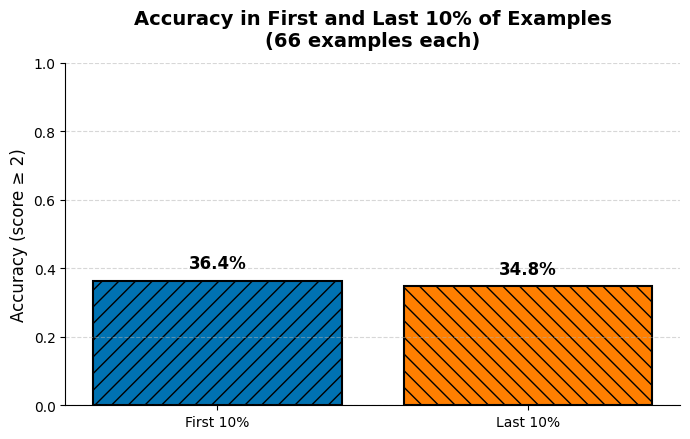

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Color-blind friendly colors and hatching
cbf_blue = "#0072B2"
cbf_orange = "#FF7F00"
bar_colors = [cbf_blue, cbf_orange]
bar_hatch = ['//', '\\\\']

# Calculate the number of rows for 10%
n = len(df)
n_10 = max(1, int(n * 0.1))

# Get indices for first 10% and last 10%
first_10_idx = df.index[:n_10]
last_10_idx = df.index[-n_10:]

# Calculate accuracy (fraction of score >= 2) in first 10% and last 10%
first_10_acc = (df.loc[first_10_idx, 'score'] >= 2).mean()
last_10_acc = (df.loc[last_10_idx, 'score'] >= 2).mean()

# Bar chart
labels = ['First 10%', 'Last 10%']
accuracies = [first_10_acc, last_10_acc]

fig, ax = plt.subplots(figsize=(7, 4.5))
bars = ax.bar(labels, accuracies, color=bar_colors, edgecolor='black', linewidth=1.5)

# Add hatching for style
for bar, hatch in zip(bars, bar_hatch):
    bar.set_hatch(hatch)

# Add value labels above bars, bold and larger font
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.annotate(f"{acc*100:.1f}%",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 6),  # 6 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy (score ≥ 2)', fontsize=12)
ax.set_title(f'Accuracy in First and Last 10% of Examples\n({n_10} examples each)', fontsize=14, fontweight='bold', pad=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('long_term_memory_experiment_first_10_percent.png', dpi=300, bbox_inches='tight')
plt.show()


,tool_name,count
0,get_database_schema,658
1,run_sql_against_database,599
2,look_up_evidence,346
3,log_evidence,227


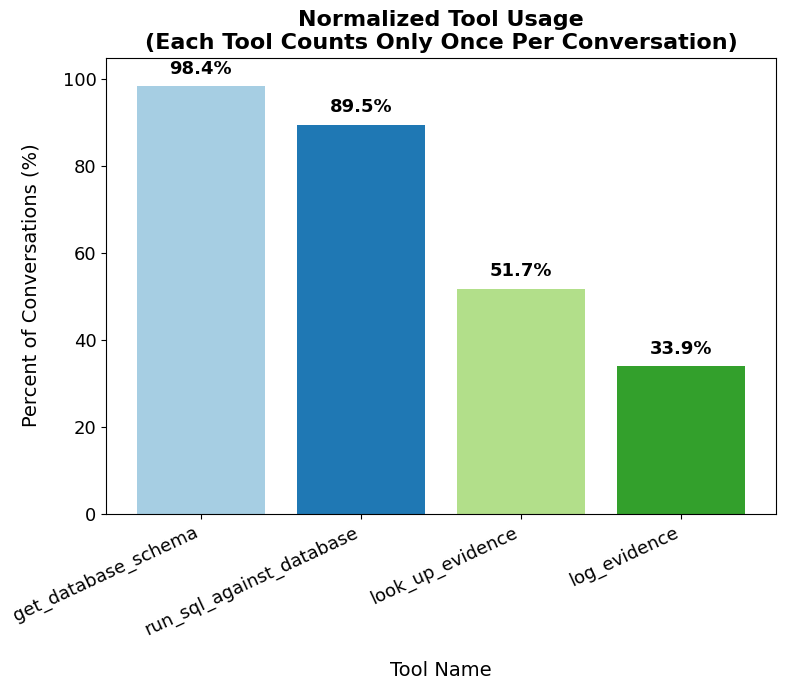

In [12]:
import ast
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Parse all tool_messages and extract tool names, counting each tool only once per row
tool_names = []
for msgs in df['tool_messages']:
    try:
        # Some entries may be string representations of lists of dicts
        parsed = ast.literal_eval(msgs)
        row_tools = set()
        if isinstance(parsed, list):
            for msg in parsed:
                if isinstance(msg, dict) and 'name' in msg:
                    row_tools.add(msg['name'])
        tool_names.extend(row_tools)
    except Exception as e:
        print(e)
        continue

# Count occurrences of each tool name (each tool only once per row)
tool_name_counts = Counter(tool_names)

# Show as DataFrame
tool_name_df = pd.DataFrame(tool_name_counts.items(), columns=['tool_name', 'count']).sort_values('count', ascending=False)
display(tool_name_df)

# Bar chart of normalized tool usage (percent of total rows, 0-100%)
plt.figure(figsize=(8, 7))
total_rows = df.shape[0]
tool_name_df['percent'] = tool_name_df['count'] / total_rows * 100

bars = plt.bar(tool_name_df['tool_name'], tool_name_df['percent'], color=plt.cm.Paired(range(len(tool_name_df))))
plt.title('Normalized Tool Usage\n(Each Tool Counts Only Once Per Conversation)', fontsize=16, fontweight='bold')
plt.xlabel('Tool Name', fontsize=14, labelpad=16)
plt.ylabel('Percent of Conversations (%)', fontsize=14, labelpad=16)
plt.ylim(0, 105)
plt.xticks(fontsize=13, rotation=25, ha='right')
plt.yticks(fontsize=13)
plt.subplots_adjust(bottom=0.20, left=0.18, right=0.98, top=0.88)  # Add more space for labels

# Add value labels on top of bars
for bar, pct in zip(bars, tool_name_df['percent']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('tool_name_usage_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
df = df[['score', 'final_response', 'question', 'ground_truth_answer', 'vector_store_size']]

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate rolling mean and median
WINDOW_N = 50
print(f"Window size: {WINDOW_N}")

# Rolling mean score and rolling min vector_store_size
rolling_df = df[['score', 'vector_store_size']].rolling(window=WINDOW_N).agg({'score': 'mean', 'vector_store_size': 'min'}).dropna()

# Calculate rolling % of score >= 2
score_is_2 = (df['score'] >= 2).astype(int)
score_not_2 = (df['score'] < 2).astype(int)

rolling_pct_2 = score_is_2.rolling(window=WINDOW_N).mean().dropna()
rolling_pct_not_2 = score_not_2.rolling(window=WINDOW_N).mean().dropna()

# Add to rolling_df for convenience (align indices)
rolling_df['pct_score_2'] = rolling_pct_2.loc[rolling_df.index]
rolling_df['pct_score_not_2'] = rolling_pct_not_2.loc[rolling_df.index]

rolling_df.tail()

Window size: 50


,score,vector_store_size,pct_score_2,pct_score_not_2
664,1.10,217.0,0.34,0.66
665,1.10,217.0,0.34,0.66
666,1.10,217.0,0.34,0.66
667,1.16,217.0,0.36,0.64
668,1.10,217.0,0.34,0.66


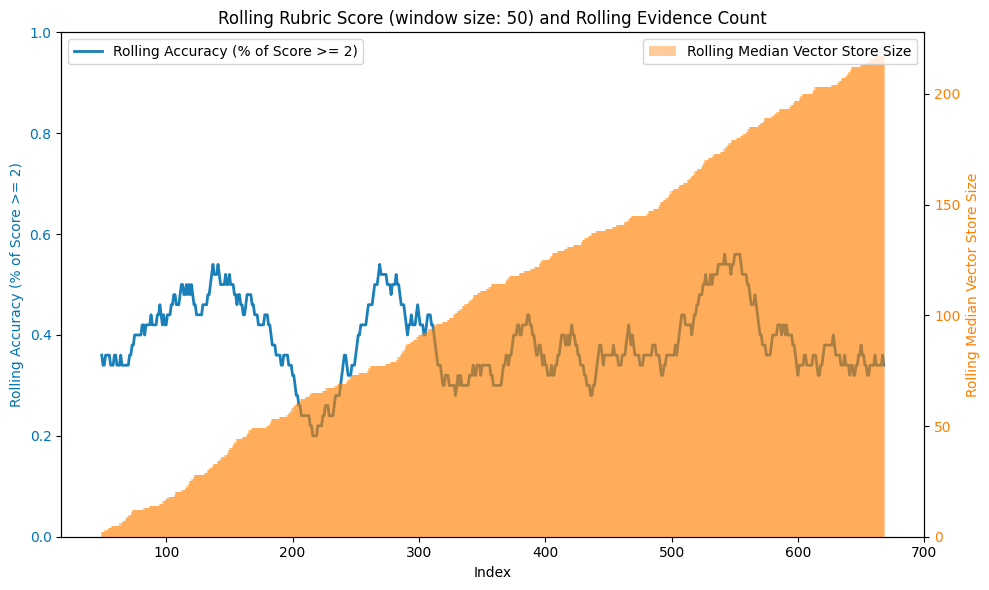

In [9]:
# Use color-blind friendly colors: blue replaced with #0072B2 (blue), orange replaced with #E69F00 (orange)
# See: https://davidmathlogic.com/colorblind/

cbf_blue = "#0072B2"
cbf_orange = "#FF7F00"

fig, ax1 = plt.subplots(figsize=(10,6))

# Use line plots for rolling mean score
ax1.plot(
    rolling_df.index,
    rolling_df['pct_score_2'],
    color=cbf_blue,
    alpha=0.9,
    label='Rolling Accuracy (% of Score >= 2)',
    linewidth=2
)
ax1.set_xlabel('Index')
ax1.set_ylabel('Rolling Accuracy (% of Score >= 2)', color=cbf_blue)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor=cbf_blue)

# Create a second y-axis for vector_store_size as a bar plot
ax2 = ax1.twinx()
ax2.bar(
    rolling_df.index,
    rolling_df['vector_store_size'],
    color=cbf_orange,
    alpha=0.4,
    label='Rolling Median Vector Store Size',
    width=2
)
ax2.set_ylabel('Rolling Median Vector Store Size', color=cbf_orange)
ax2.tick_params(axis='y', labelcolor=cbf_orange)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f'Rolling Rubric Score (window size: {WINDOW_N}) and Rolling Evidence Count')
plt.tight_layout()
plt.savefig("long_term_memory_experiment.png")
plt.show()